In [75]:
# -*- coding: utf-8 -*-
"""
@author: Yang Li
"""
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
import numpy as np
from torch.autograd import Variable
import torch.optim as opt

In [76]:
def conv3x3(in_planes, out_planes):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3,
                     padding=1, bias=False)
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, planes):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(planes, planes)
        self.bn1 = nn.InstanceNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.InstanceNorm2d(planes)
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out
class ResNet(nn.Module):
    def __init__(self, feature_size,hidden_size=64):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(feature_size, hidden_size, kernel_size=1, bias=False)# transit layer
        self.bn1 = nn.InstanceNorm2d(hidden_size) 
        self.relu = nn.ReLU(inplace=True)
        self.resblock1=BasicBlock(hidden_size)#first block
        self.resblock2=BasicBlock(hidden_size)#second block
        self.conv2 = nn.Conv2d(hidden_size, 1, kernel_size=1)
        self.sig=nn.Sigmoid()# final activition function : sigmoid
    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.resblock1(x)
        x=self.resblock2(x)
        x=self.conv2(x)
        x=self.sig(x)
        return x

Now we have built a resnet with 2 residual blocks. Time for training and testing

In [77]:
train_x=np.load('T0918-D3.2d.npy')
print(train_x.shape)
train_y=np.genfromtxt('T0918-D3.contact')
test_x=np.load('T0859-D1.2d.npy')
test_y=np.genfromtxt('T0859-D1.contact')
print(test_x.shape)

(445, 118, 118)
(445, 113, 113)


what two proteins look like 


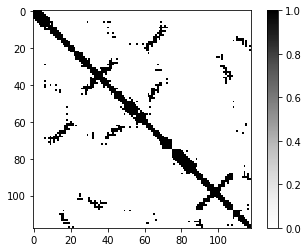

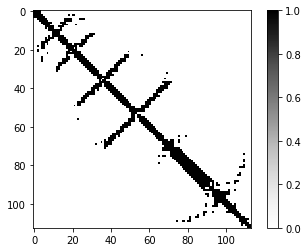

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


In [78]:
import matplotlib.pyplot as plt
def plotmatrix(x):
    try:
        plt.imshow(x,cmap='Greys');
        plt.colorbar()
        plt.show()
    except:
        print('Unable to plot!')
train_y[train_y<8.0]=1
train_y[train_y>=8.0]=0
test_y[test_y<8.0]=1
test_y[test_y>=8.0]=0
plotmatrix(train_y)
plotmatrix(test_y)
train_x,train_y=Variable(torch.FloatTensor(np.array([train_x]))),Variable(torch.FloatTensor(train_y))
test_x,test_y=Variable(torch.FloatTensor(np.array([test_x])),volatile=True),Variable(torch.FloatTensor(test_y),volatile=True)

How maybe we should find a function to guide the model training, the loss function cross entropy loss function
I prefer writing my own loss function 


In [79]:
def loss_function(output,target,epsilon=1e-8,):
    losses=  -(target* torch.log(output + epsilon)  + 
              (1. - target) * torch.log( 1. - output +epsilon)                        )
    loss= torch.mean(losses)
    return loss 

In [80]:
model=ResNet(445,64)
model.eval()
pred0=model(test_x)
loss=loss_function(pred0,test_y)
print('Random loss:',loss.data[0])


    

Random loss: tensor(0.7249)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [81]:
optimizer=opt.Adam(model.parameters())
model.train()
for i in range(100):
    optimizer.zero_grad()
    y_pred=model(train_x)
    aloss=loss_function(y_pred,train_y)
    aloss.backward()
    optimizer.step()
    if i>0 and i%10==0:
        print(i,'th training loss:',aloss.data[0])
        model.eval()
        predi=model(test_x)
        loss=loss_function(predi,test_y)
        print(i,'th validation loss:',loss.data[0])  
        model.train()
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


10 th training loss: tensor(0.2864)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


10 th validation loss: tensor(0.3629)
20 th training loss: tensor(0.2072)
20 th validation loss: tensor(0.3088)
30 th training loss: tensor(0.1598)
30 th validation loss: tensor(0.2765)
40 th training loss: tensor(0.1254)
40 th validation loss: tensor(0.2571)
50 th training loss: tensor(0.0996)
50 th validation loss: tensor(0.2500)
60 th training loss: tensor(0.0785)
60 th validation loss: tensor(0.2407)
70 th training loss: tensor(0.0584)
70 th validation loss: tensor(0.2341)
80 th training loss: tensor(0.0407)
80 th validation loss: tensor(0.2287)
90 th training loss: tensor(0.0287)
90 th validation loss: tensor(0.2225)


Both training loss and validation loss are decreasing, That's good! 
But the training loss is very close to 0, which is like over-fitting, very dangerous!
The Best way to avoid over-fitting is collecting more data.